In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 11: Support Vector Machines
----

This homework will use support vector machines to classify CalEnviroScreen data. We will take gradual steps in this homework, starting from recalling key information from lectures and textbook, to creating our own classifiers. Throughout the homework, we'll learn about the intuition behind the Perceptrons and Maximal Margin Classifiers (MMC), then move on to learning about the intuition behind support vector machines (SVMs) and applying them to CalEnviroScreen data. The textbook reference here is ISLR 9.1-9.3.


### Table of Contents

[CalEnviroScreen Data](#data)<br>
1. [Perceptrons and MMC](#perceptron)<br>
1. [SVM Intuition](#svm)<br>
1. [Using SVM to Classify CalEnviroScreen Data](#classify) <br>

**Dependencies:**

In [2]:
# Import Packages
import numpy as np
import pandas as pd
from matplotlib import style
from matplotlib import pyplot as plt

# Import Samples Generator
from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Color Scheme for SVM!
colormap = np.array(['blue', 'gold']) # Go bears!

# Allows us to plot SVC decision functions
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC
    
    Variables: 
        model: classifier
    
    Usage:
    >>> from sklearn.svm import SVC
    >>> clf = SVC(kernel='linear')
    >>> clf.fit(X, y)
    >>> plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    >>> plot_svc_decision_function(clf) # Draw the decision boundary
    >>> plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [3]:
# run this cell
!pip install xlrd

---

### CalEnviroScreen Dataset <a id='data'></a>
Carrying on from the previous homework, we will be using the CalEnviroScreen dataset. CalEnviroScreen 3.0 is a comprehensive documentation of the environmental and the demographic conditions of each census tract in California. In this homework, we are interested in predicting environmental conditions using information related to demographics. 

Please note that the Excel file can be downloaded from [here](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30). However, for this homework, the Excel file has already been placed in the same directory as the homework. 

Before we get to working with the data, however, we're going to use simulated data to develop some concepts.

---
### Section 1: Perceptrons and Maximal Margin Classification  <a id='perceptron'></a>

#### What's a Perceptron?

You'll remember from the asynchronous lectures that SVM are a way to classify observations into one of two possible classes. SVMs are a pretty flexible method that can allow for non-linear splits between observations. Given a set of hyperparameters, the SVM delivers a unique solution. 

For the purposes of this homework, a perceptron is any hyperplane sitting between linearly separable data. In this way perceptrons are a little more generic than SVMs (any plane will do) and a little less flexible (the data need to be linearly separable).  

We use the following mathematical notation when we talk about perceptrons. We'll define our training dataset as $D$, and the number of points in $D$ as $n$, with the following notation:

$D = \{(x_i, y_i)\}_{i = 1}^{n}$

$x_i$ and $y_i$ have to meet certain criteria: $y_i$ can only be equal to -1 or 1, where -1 represents one class and 1 represents another class. This is expressed mathematically as:

$y_i \in \{-1 , +1\}$

We also specify that $x_i$ has to be a real number (this is not a condition that we really have to worry about in our applications of machine learning) in this way:

$x_i \in R^p$ 

$p$ is the number of features we have - i.e. $X$ is a $n \times p$ matrix.

A perceptron is a $p - 1$-dimensional hyperplane that perfectly separates $+1$ and $-1$. A hyperplane is defined as a "flat subspace of a $p$-dimensional space." 

Let's think about what this means intuitively, by considering different values of $p$. If $p = 1$, that means we're trying to divide a single set of predictors into two categories. In this case, a $(p - 1)$-dimensonal hyperplane is a 0-dimensional hyperplane - which in our case is just a single point! You can think of your $x$ values as falling along a number line, and your division being a single point on that line. If $p = 2$, we're dividing two sets of predictors into two categories, so we want a 1-dimensional hyperplane - this is a line. In this case, you can think of plotting your first predictor $x_1$ on an x-axis, and $x_2$ on a y-axis; a line can be drawn to separate observations.

**Question 1.1** If we have 3 predictors, what is the shape and dimension of a hyperplane that divides our observations into two classes? How would you plot this hyperplane?

*Your answer here*

**Answer** *The hyperplane will be a plane in 2-dimensions. You would plot it on a 3-dimensional plot, with x, y, and z axes.*

In the next question, we are going to use `make_blobs` and `make_circles` extensively. These are sample generators made by `scikit-learn` package, which--as their names imply--will allow us to randomly generate blobs and circles.

The following cell is an example of how we might call `make_blobs`.

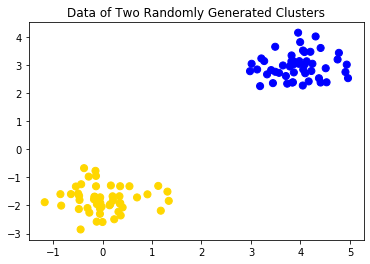

In [4]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.50, center_box=(-4, 4), random_state = 2020)

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)

**Question 1.2:** There are many hyperplanes that can separate these two clusters of data. Give 3 possible examples in the code below based on visually inspecting the plot above. We've started defining three tuples for you (`first`, `second`, and `third`), where the first item in each tuple is the slope and second item should be the y-intercept. In other words, `first/second/third = (slope, y-intercept)`.

(*Side note:* We talked about tuples at the start of the semester -- but here's a reminder: They're kind of like lists, in that they contain a sequence of values through which you can iterate, but unlike lists the values they contain can't be modified easily after they're initialized. Tuples are contained in round brackets (`()`) while lists are contained in square brackets (`[]`)).

In [5]:
# Define example hyperplanes here
# first = (..., ...)
# second = (..., ...)
# third = (..., ...)

In [6]:
# SOLUTION
# ANY REASONABLE SOLUTION based on the plots in the next cell. 
# example solution
first = (-1,3)
second = (0,1)
third = (-.5,2)

Run the following cell to double-check that your answers are right and reasonable.

(-1.6686789227883028, 5.460695831644053)

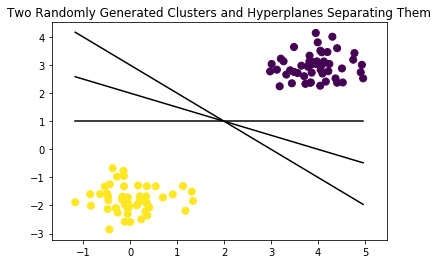

In [7]:
# Plotting 
xfit = np.linspace(X[:,0].min(), X[:,0].max())
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

for m, c in [first, second, third]:
    plt.plot(xfit, m * xfit + c, '-k')

plt.title("Two Randomly Generated Clusters and Hyperplanes Separating Them")
plt.xlim(xfit.min()-0.5, xfit.max()+0.5)

<b> Question 1.3: </b> There are multiple answers (we definitely know there are at least 3!) to Question 1.2. Explain why. 

*Your answer here*

**Answer** *If our data can be perfectly separated using a hyperplane, then there will in fact exist an infinite number of such hyperplanes. A given separating hyperplane can be shifted a little up or down, or rotated, without coming into contact with any of the observations*

**Question 1.4:** The issue explored above - i.e., that a dataset can allow for multiple hyperplanes that divide it - lead us to use maximal marginal classification (MMC) or hard-margin SVM in practice. In a few sentences, explain what differentiates MMC from the perceptrons that we've explored above.

*Your answer here*

**Answer** *In order to construct a classifier based upon a separating hyperplane, we must have a reasonable way to decide which of the infinite possible separating hyperplanes to use. Hard-margin SVM is a natural choice that chooses the hyper-plane farthest from the training observations. This gives more room and accuracy when we test.*

We are now going to examine how to code Perceptrons, especially since this process is very similar to that used to code SVMs (which we will see later in the homework). First, we import the necessary library: 

In [8]:
from sklearn.linear_model import Perceptron

Next, we'll create our artificial dataset which has been hard-coded below. Later, we will use `scikit-learn`'s `samples_generator` to create our datasets. But, for now, let's try to develop a better understanding of the kind of data that we use to classify information.

In [9]:
x = np.array([
[2, 1, 2, 5, 8, 2, 3, 6, 1, 2, 5, 5, 5, 5, 6],
[2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 4, 7, 5, 7, 3]
])

y = np.array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1])

**Question 1.5:** Qualiatatively describe what `x` and `y` represent in the above block of code. What will the coordinate $(1, 3)$ be classified as?

*Hint*: `x` and `y` above function similarly to the `X` and `y` that were assigned as the output of `make_blobs()` a few questions ago!

*Your answer here*

**Answer** *`x` contains the values of the features and `y` contains the classes for each coordinate. $(1, 3)$ will be labelled as $0$*

Now that we have developed an understanding of what our data is, let's plot it.

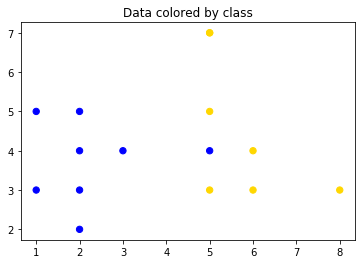

In [10]:
plt.title("Data colored by class")
plt.scatter(x[0], x[1], c=colormap[y], s=40)

**Question 1.6:** Based on the graph, is this dataset linearly separable? Why or why not?

*Your answer here*

**Answer** *The dataset is not linearly separable, because of Point $(5, 4)$*

Now, we are going to try building code the finds perceptrons, using a modified dataset defined below:

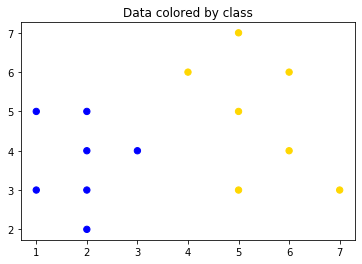

In [11]:
data = np.array([
[2, 1, 2, 5, 7, 2, 3, 6, 1, 2, 5, 4, 6, 5],
[2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 7]
])

label = np.array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])
plt.title("Data colored by class")
plt.scatter(data[0], data[1], c=colormap[label], s=40)

**Question 1.7:** In the following block, set up our classifier, using `Perceptron`. Look at the following [link](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) for more information on setting up a classifier with Perceptron. We want the model to have the following parameters:
1. `max_iter` = 100
2. `verbose` = 0
3. `eta0` = 0.001

In [12]:
# # YOUR CODE HERE
# classifier = ...

In [13]:
classifier = Perceptron(max_iter=100, verbose=0, eta0=0.001)

**Question 1.8** In the following block, fit the Perceptron classifier you set up in Question 1.7. Again, please refer to the following [link](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) for more information on using the classifier. 

Before we run `.fit()`, take a look at the above documentation for `Perceptron()`. Which variables will we use as the `X` and `y` inputs? Are their dimensions correct? If not, make any adjustments needed and then run `classifier.fit()`.

In [14]:
# # YOUR CODE/ANSWER HERE
# ...
# classifier.fit(...)

In [15]:
# SOLUTION
# transpose the data
dataT = data.T
classifier.fit(dataT, label)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.001,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Finally, let's run the following cell to see what kind of decision boundary we have come up with!

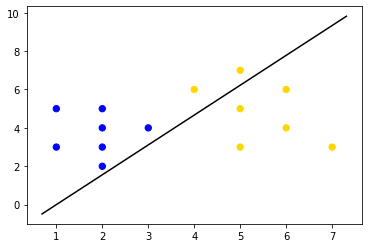

In [16]:
# Plot the original data
plt.scatter(data[0], data[1], c=colormap[label], s=40)

# Calc the hyperplane (decision boundary)
xmin, xmax = plt.xlim()

w = classifier.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xmin, xmax)
yy = a * xx - (classifier.intercept_[0]) / w[1]

# Plot the line
plt.plot(xx, yy, 'k-')

**Question 1.9** In this question, repeat the steps in questions 1.7-1.8, but this time pass a value other than the default to the arguments `penalty` and `n_iter_no_change` (read the docstring or documentation above to figure out possible arguments for `penalty`. Pass a value greater than 5 to `n_iter_no_change`). How does the decision boundary change? What is changing about our implementation of the algorithm when we modify these parameters?

In [17]:
# YOUR CODE HERE

*Your answer here*

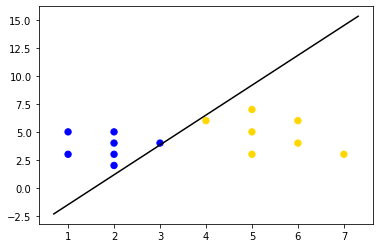

In [18]:
# possible solution
classifier = Perceptron(penalty = 'elasticnet', max_iter=100, verbose=0, eta0=0.002, n_iter_no_change = 20)
classifier.fit(dataT, label)

# Plot the original data
plt.scatter(data[0], data[1], c=colormap[label], s=40)

# Calc the hyperplane (decision boundary)
xmin, xmax = plt.xlim()

w = classifier.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xmin, xmax)
yy = a * xx - (classifier.intercept_[0]) / w[1]

# Plot the line
plt.plot(xx, yy, 'k-')
plt.show()

Note that the Perceptron Algorithm implemented here is satisfied when it finds *any* hyperplane that separates the data.  You can probably see that other hyperplanes would leave more "room" between the data at the hyperplane.  That's where maximal margin algorithms (which underlie SVM) come in.

---
### Section 2: SVM Intuition <a id='svm'></a>

Before we start classifying the CalEnviroScreen Dataset, let's review the intuition behind using Support Vector Machines. 

<img src="svd.png" width="400">

This is an example of an artificially created data-set to be classified, where red $+$ data points and green $\large{\circ}$ data points represent two different classes. In the following questions, assume the following: 
1. Training data comes from error-prone sensors, so we're not that confident in the location of any one point,
2. We are training our SVM using a __quadratic__ kernel. The hyperparameter $C$ will determine the location of the separating hyperplane.

Answer the following questions with a one line justification.

**Question 2.1** Given the potential decision boundaries below, which one has a large $C$ (i.e. $C \to \infty$) and which one has a small $C$ (i.e. $C \to 0$)?

<img src="svd2.png" width="400">

*Your answer here*

**Answer** *Left will have small C, right will have a large C*

**Question 2.2** In this particular dataset, why might it be more advantageous to use a large value of $C$ than a small $C$ one?

*Your answer here*

**Answer** *It is more advantageous to use a large $C$ since we are asked to assume that we should not trust any particular point, so we prefer $C \to inf$ because it maximizes the margin between the dominant cluster of points.*

**Question 2.3** Imagine you've received one additional data point in the green circle class. Name one coordinate this data point could have that will **not change** the decision boundary for small values of C. Justify your answer.

*Your answer here*

**Answer** *Any reasonable answer, for example addition of Green $(10, 10)$. The reason is that this point will not become a new support vector; it fits in very nicely with the currently trained model*

**Question 2.4** Name one coordinate the new data point could have that **will** change the decision boundary learned for small values of $C$. Justify your answer.

*Your answer here*

**Answer** *Any reasonable answer, for example, addition of Green $(4, 6)$*

Before we begin the next set of questions, run the following cell to import the module we need to run SVM using `scikit-learn`. We will also call the different libraries that we will be using in this question, namely `samples_generator`.

In [19]:
from sklearn.svm import SVC

In this question, we are going to use `make_blobs` again. Run the cell below to generate another set of random blobs.

Keep this code in mind as you will later be asked to call `make_circles`. 

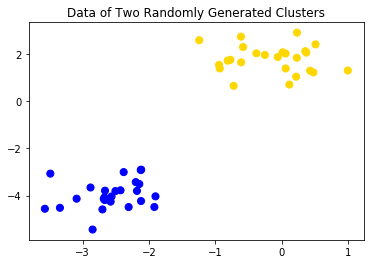

In [20]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.60, center_box=(-4, 4), random_state = 11)

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)

Let's now use support vector machines to classify our data. 

**Question 2.5** Make the Support Vector Machine Classifier in the following cell with a linear kernel.

*Hint:* Use `SVC` to create your model and refer to this [link](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for more information. **Important note:** Pay close attention to the definition of the parameter `C` as applied in scikit-learn! It's not quite the same as the hyperparameter $C$. 

Then, fit your support vector machine on the data. Remember, the data for blobs is `X` and labels are `y`.

In [21]:
# # YOUR CODE HERE
# clf = ...

In [22]:
# SOLUTION
clf = SVC(kernel='linear')
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Now, let's have a look at what we have made by running the following cell.

Text(0.5, 1.0, 'SVM on the Blobs of Data')

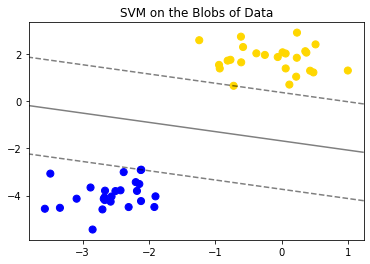

In [23]:
# Graphing SVM and Data
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)

plt.title("SVM on the Blobs of Data")

So far, we have only really dealt with linearly separable data. What happens if the data is not linearly separable? Let's examine these cases in the following questions. 

**Question 2.6** Just as we have created our dataset for blobs of data, make a new dataset for circles below. Plot that data, using different colors for the different classes of data.

*Hint: Refer to the code above and use the function `make_circles`[https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html]*

In [24]:
# # YOUR CODE HERE
X, y = make_circles(100, factor=.1, noise=.2)

# # plot data

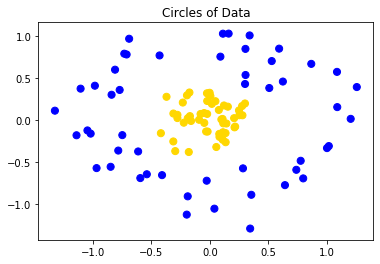

In [25]:
# SOLUTION
X, y = make_circles(100, factor=.1, noise=.2)

# Graphing data points
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plt.title("Circles of Data")
plt.show()

**Question 2.7**: Train this new dataset using a linear kernel and plot the points along with the decision boundary, using the function `plot_svc_decision_function()`.

In [26]:
# YOUR CODE HERE

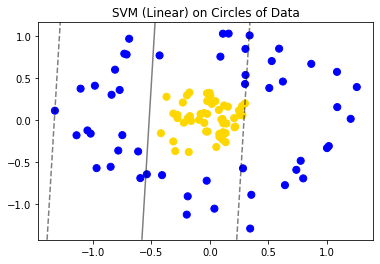

In [27]:
clf = SVC(kernel='linear', C=1) # any value of c works as long as it is low!
clf.fit(X, y)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM (Linear) on Circles of Data")
plt.show()

The linear kernel doesn't really do a good job of distinguishing these two classes. Let's try a radial basis kernel, called `"rbf"` in scikit-learn. 

**Question 2.8** Repeat the steps in question 2.7, but with a radial basis kernel.

In [28]:
# YOUR CODE HERE


C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


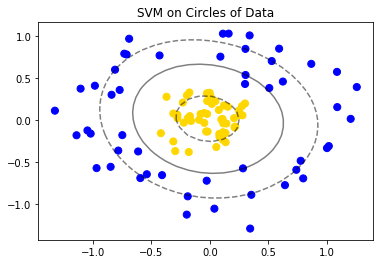

In [29]:
# SOLUTION 
clf = SVC(kernel='rbf')
clf.fit(X, y)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM on Circles of Data")
plt.show()

---
### Section 3: Using SVM to Classify CalEnviroScreen Data <a id='classify'></a>

<br>
Now that we've explored how SVM works and how to implement it, let's begin applying our knowledge on the CalEnviroScreen dataset.

In [30]:
# run this cell
env = pd.read_excel('ces3results.xlsx')
demog = pd.read_excel('ces3results.xlsx', sheet_name = 3, header = 1)
demog = demog.rename(columns = {'Unnamed: 0': 'Census Tract',
                          'Unnamed: 1': 'CES 3.0 Score',
                          'Unnamed: 2': 'CES 3.0 Percentile',
                          'Unnamed: 3': 'CES 3.0 Percentile Range',
                          'Unnamed: 4': 'Total Population',
                          'Unnamed: 5': 'California County'
    
})

Second, let's have a look at what each of these dataframes contains (these should look familiar from HW10).

In [31]:
env.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


In [32]:
demog.head()

,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
0,6019001100,94.090246,100.000000,95-100% (highest scores),3174,Fresno,18.8,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8
1,6071001600,90.677839,99.987388,95-100% (highest scores),6133,San Bernardino,19.7,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7
2,6019000200,85.970036,99.974776,95-100% (highest scores),3167,Fresno,21.5,72.5,6.0,63.6,5.3,18.9,0.6,9.8,1.8
3,6077000801,82.491521,99.962164,95-100% (highest scores),6692,San Joaquin,18.7,74.5,6.8,57.4,6.0,12.5,0.3,20.9,2.8
4,6019001500,82.030814,99.949552,95-100% (highest scores),2206,Fresno,14.8,72.1,13.1,71.8,21.4,1.2,0.5,4.5,0.6


Before we get started, we'll select only the columns we want. We'll be predicting the Percentile Range based on Unemployment and PM2.5, and we'll only be looking at records with a percentile > 95% or < 5%. Run the cell below to grab just those columns and rows and remove any NAs.

In [33]:
# run this cell
env_model = env[['Unemployment', 'PM2.5','CES 3.0 \nPercentile Range']]
env_model = env_model.loc[env_model['CES 3.0 \nPercentile Range'].isin(['95-100% (highest scores)', '1-5% (lowest scores)'])]
env_model.dropna(inplace = True)
env_model.head()

,Unemployment,PM2.5,CES 3.0 Percentile Range
0,17.6,15.40,95-100% (highest scores)
1,12.3,13.31,95-100% (highest scores)
2,16.1,15.40,95-100% (highest scores)
3,19.6,12.54,95-100% (highest scores)
4,18.6,15.40,95-100% (highest scores)


**Question 3.1:** Now, given the dataframe `env_model`, create a dataframe `X` that contains the predictors and `y` that contains the response. Then, split `X` and `y` into train and test sets, using an 80/20 train/test split and a `random_state` of your choice.

In [34]:
# YOUR CODE HERE

In [35]:
# SOLUTION
X = env_model.iloc[:,0:2]
y = env_model.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)  

**Question 3.2:** Let's start classifying information now. Below, like *Question 2.7*, make a SVM classifier with a linear kernel (choose $C$ of your choice! If it takes too long, it is probably too high) and train the data. 

*Hint: If you get the error,* 

>`DataConversionWarning`: A column-vector ?? was passed when a `1d` array was expected. Please change the shape of ?? to (n_samples, ), for example using `ravel()`

*use ??.values.ravel() to override this issue*

In [36]:
# YOUR CODE HERE

In [37]:
# SOLUTION
svclassifier = SVC(kernel='linear', C=5)  
svclassifier.fit(X_train, y_train) 

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

**Question 3.3:** Use the classifier to predict the outcome of our `X_test` and save the output to `y_pred`.

In [38]:
# YOUR CODE HERE

In [39]:
# SOLUTION
y_pred = svclassifier.predict(X_test)  

Congratulations! You have completed training a data-set. Run the box below to see if you are getting a reasonable percentage of correct matches.

In [40]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[77  1]
 [ 3 76]]
                          precision    recall  f1-score   support

    1-5% (lowest scores)       0.96      0.99      0.97        78
95-100% (highest scores)       0.99      0.96      0.97        79

                accuracy                           0.97       157
               macro avg       0.97      0.97      0.97       157
            weighted avg       0.97      0.97      0.97       157



**Question 3.4** Interpret the values in the confusion matrix. What does each of the four values mean? The [documentation for `confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) is a good reference.

*Your answer here*

**Solution:** 
* *Top left: the number of samples that were actually in the "1-5% (lowest scores)" class that were correctly classified.*
* *Top right: the number of samples actually in the "1-5% (lowest scores)" class that were incorrectly classified as "95-100% (highest scores)".*
* *Lower left: the number of samples actually in the "95-100% (highest scores)" class that were incorrectly classifed as "1-5% (lowest scores)".*
* *Lower right: the number of samples actually in the "95-100% (highest scores)" class that were correctly classified.*

**Question 3.5** Based on the classification report, are there more false positives for the "lowest score" class or are there more false negatives? Which values in the classification report give you this information?

For reference, see the documentation for [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html); scrolling down to the "Returns" section and following relevant links there will also be helpful.

*Your answer here*

**Answer**: *there are more false positives, based on the precision ratio and recall ratio. The precision ratio is smaller than the recall ratio, and contains false positives in the denominator, while the recall ratio contains false negatives.*

Run the cell below to see what our classification looks like! Note that this code assumes that `y` is a Pandas series and `X` is a Pandas dataframe; if you set up your `X` and `y` differently you may have to make slight modifications where those variables are called.

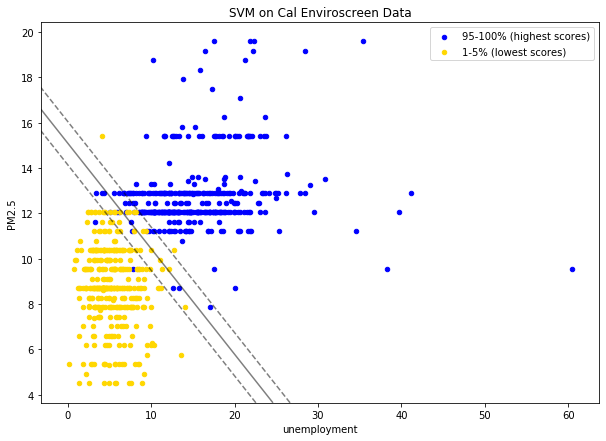

In [41]:
# run this cell
plt.figure(figsize = (10,7))

classes = pd.unique(y)
y_label = np.array([np.where(classes == i)[0][0] for i in y.values])

labels = [None]*len(y_label)
for i in classes:
    labels[np.where(y == i)[0][0]] = i

for i in range(len(X)):
    plt.scatter(X.iloc[i, 0], X.iloc[i, 1], c=colormap[y_label[i]], s=20, label = labels[i])

plot_svc_decision_function(svclassifier)

plt.xlabel("unemployment")
plt.ylabel("PM2.5")
plt.title("SVM on Cal Enviroscreen Data")

plt.legend()

---
## Submission

Congrats, you finished the final homework!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.html** and submit the file through bCourses.

---

## Bibliography

Carnegie Mellon University's Machine Learning Course (10 - 701) - Images on Question 2 - http://www.cs.cmu.edu/~ninamf/courses/601sp15/lectures.shtml

Jayanta Basak, *A Least Square Kernel Machine with Box Constraints* - Inspiration and Formula for Question 4.4 - http://www.jprr.org/index.php/jprr/article/viewfile/181/57

Jake VanderPlas - Function for Drawing SVC Decision Boundaries - *Python Data Science Handbook*

---
Notebook developed by: Beom Jin Lee (Brian)

Data Science Modules: http://data.berkeley.edu/education/modules
